In [0]:
%%capture
!apt install -y cmake
!pip install gym
!pip install gym[atari]
!pip install scikit-image


In [0]:
from skimage import color, transform
import sys
import gym
import pylab
import random
import numpy as np
from collections import deque
from keras.layers import Dense, Reshape, Flatten, Activation
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras.models import Sequential

MEMORY_SIZE = 250000 # because is what we can
N_ACTIONS = 3
ACTIONS = [0,2,3]
BATCH = 32
GAMMA = 0.99
EPISODES = 50000
EPSILON = 1.0
EPSILON_DECAY = 0.0000009
EPSILON_MIN = 0.1
LEARNING_RATE = 0.00025
EPOCH_SIZE = 50000   # epoch size of the paper (Mnih et al, 2013). Aproximately 40 min per epoch, a reasonable time, vs 250000 steps per epoch
UPDATE_FRECUENCY = 10000 # taken from the paper


# to gray and reescale
def process(img):
    # img = color.rgb2gray(img)
    # return transform.resize(img,(80,80), mode='constant')
    # return np.array(Image.fromarray(img, 'RGB').convert('L').resize((80,80), Image.ANTIALIAS))
    
    # this is by far the best method. Faster and provides a clearer image than the others
    # inspirado en: https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5
    img = img[35:195] # crop
    img = img[::2,::2,0] # downsample by factor of 2
    img[img == 144] = 0 # erase background (background type 1)
    img[img == 109] = 0 # erase background (background type 2)
    img[img != 0] = 1 # everything else (paddles, ball) just set to 1
    return img.astype(np.int8)#.ravel()


def concatenate(imgs):
    return np.stack(imgs, axis=2)


def max_pooling(imgs):
    return np.amax(imgs, axis=0)


def choose_action(model=None, epsilon=1, state=None):
    if np.random.rand() <= epsilon:
        return np.random.randint(N_ACTIONS)
    else:
        q_value = model.predict(state)
        return np.argmax(q_value[0])


def build_model():
    model = Sequential()
    model.add(Conv2D(32, (8, 8), strides=(4,4), padding="same", input_shape=(80,80,4)))
    model.add(Activation("relu"))
    model.add(Conv2D(64, (4, 4), strides=(2,2), padding="same"))
    model.add(Activation("relu"))
    model.add(Conv2D(64, (3, 3), strides=(1,1), padding="same"))
    model.add(Activation("relu"))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation("relu"))
    model.add(Dense(3))
    model.compile(loss='mse',optimizer=Adam(lr=LEARNING_RATE))
    return model

model = build_model()
model.summary()
target_model = build_model()
target_model.set_weights(model.get_weights())


def next_state(env, a_0):
    states = np.zeros(shape=(4, 80, 80))
    rewards = np.zeros(shape=(4,))
    dones = np.zeros(shape=(4,))
    real_action = ACTIONS[a_0] # 0,1,2 -> 0,2,3
    for i in range(4):
        state, reward, done, _ = env.step(real_action)
        state = process(state)
        states[i] = state
        rewards[i] = reward
        dones[i] = done
    # down size the data
    return (np.int8(i) for i in (max_pooling(states), sum(rewards), np.amax(dones)))


def fill_memory(env, memory):
    a_0 = choose_action()
    state, reward, done = next_state(env, a_0)
    s_t = np.stack((state, state, state, state), axis=2)
    s_t = s_t.reshape(1, *s_t.shape)
    for i in range(MEMORY_SIZE):
        a_t = choose_action()
        state, r_t, done = next_state(env, a_t)
        x_t1 = state.reshape(1, state.shape[0], state.shape[1], 1) # (1, 80, 80, 1)
        s_t1 = np.append(x_t1, s_t[:, :, :, :3], axis=3) # s_(t+1)
        record = [s_t, a_t, r_t, s_t1, done]
        memory.append(record)
        s_t = s_t1
    return memory

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 20, 20, 32)        8224      
_________________________________________________________________
activation_17 (Activation)   (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 10, 10, 64)        32832     
_________________________________________________________________
activation_18 (Activation)   (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 10, 10, 64)        36928     
_________________________________________________________________
activation_19 (Activation)   (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 6400)              0         
__________

**Actividad 1**
La cantidad de parámetros corresponde a 3.356.835, eso dada la estructura de redes convolucionales utilizada, y las capas densas finales.

In [0]:
env = gym.make("PongDeterministic-v4") 
# as used in the paper (Mnih et al, 2013). 
# This means each action corresponds to exactly 4 frames in the game

env.reset()

memory = deque(maxlen=MEMORY_SIZE)
memory = fill_memory(env, memory)

In [0]:
steps = 0
epoch = 0
e = 0
epoch_info = [deque(maxlen=100) for _ in range(500)]
epsilon = EPSILON
BACKUP = False

### Backup

In [1]:
import cPickle as pickle

def save(variable, path):
    with open(path, 'w') as f:
        pickle.dump(variable, f)
    
def load(path):
    with open(path, 'r') as f:
        return pickle.load(f)
    


In [2]:
from googleapiclient.http import MediaFileUpload
from googleapiclient.http import MediaIoBaseDownload
import io
from google.colab import auth
from googleapiclient.discovery import build
auth.authenticate_user()
drive_service = build('drive', 'v3')


def create_file(name, media, parents):
    file_metadata = {
      'name': name,
      # 'mimeType': 'text/plain',
      'parents': parents,
      'uploadType' : 'resumable',
    }
    return drive_service.files().create(body=file_metadata,
                                           media_body=media,
                                           fields='id').execute()

def file_media(path):
    return MediaFileUpload(path, resumable=True)


def update_file(name, media, file_id):
    file_metadata = {
      'name': name,
      'uploadType' : 'resumable',  

    }
    f = drive_service.files()
    return f.update(body=file_metadata, media_body=media, fileId=file_id).execute()


def download(file_id, name=None):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
      _, done = downloader.next_chunk()

    downloaded.seek(0)
    if name:
        with open(name, 'w') as f:
            f.write(downloaded.read())
    else:
        return downloaded

In [12]:
if 0: # donwload from backup in drive
    model_file_id = '1fm2SNAL9KZLtE3FYXW_kU37nOS1SyvQU'
    target_model_file_id = '12AYz7ho0P-whqSIKa2vXYdHpha29XpRE'
    variables_file_id = '1dvNmdijHCagogYKngdd3_Ir-W4YTL827'

    name = 'model.hdf5'
    download(model_file_id, name)
    # model.load_weights(name)

    name = 'target_model.hdf5'
    download(target_model_file_id, name)
    # target_model.load_weights(name)

    f = download(variables_file_id)
    steps, epoch, e, epoch_info2, epsilon = pickle.loads(f.read())
    print(epoch)


49


In [0]:
parents = ['17aBHDswRwasVXoSgnKJFJGO83ZM3x1y4', '19MmX3GHcLjhabnopsixVKtrbw_v7clDA'] # /Colab Notebooks/Tarea3
# backup model
model.save_weights('./model_v0_e%d.hdf5' % epoch)

target_model.save_weights('./target_model_v0_e%d.hdf5' % epoch)

save((steps, epoch, e, epoch_info, epsilon) , './variables_v0.pickle')

model_name = 'model2'
target_model_name = 'target_model2'
variables_name = 'variables2'
if 0:
    # create files
    file = create_file(model_name, file_media('./model_v0_e%d.hdf5' % epoch), parents)
    model_file_id = file.get('id')
    print("model_file_id = '" + model_file_id + "'")

    file = create_file(target_model_name, file_media('./target_model_v0_e%d.hdf5' % epoch), parents)
    target_model_file_id = file.get('id')
    print("target_model_file_id = '" + target_model_file_id + "'")

    file = create_file(variables_name, file_media('./variables_v0.pickle'), parents)
    variables_file_id = file.get('id')
    print("variables_file_id = '" + variables_file_id + "'")


In [0]:
model_file_id = '1fm2SNAL9KZLtE3FYXW_kU37nOS1SyvQU'
target_model_file_id = '12AYz7ho0P-whqSIKa2vXYdHpha29XpRE'
variables_file_id = '1dvNmdijHCagogYKngdd3_Ir-W4YTL827'
if 0:
    update_file(model_name, file_media('./model_v0_e%d.hdf5' % epoch), model_file_id)
    update_file(target_model_name, file_media('./target_model_v0_e%d.hdf5' % epoch), target_model_file_id)
    update_file(variables_name, file_media('./variables_v0.pickle'), variables_file_id)

### Actual training

In [0]:

# main function
print('begin')


for e in range(e, EPISODES):
    state = process(env.reset())
    s_t = np.stack((state, state, state, state), axis=2)
    s_t = s_t.reshape(1, s_t.shape[0], s_t.shape[1], s_t.shape[2])
    done = False
    score = 0
    # no_ops = 0
    while not done:

        # add new action to memory
        a_t = choose_action(state=s_t, epsilon=epsilon, model=model)
        #print(a_t)
        state, reward, done = next_state(env, a_t)
        x_t1 = state.reshape(1, state.shape[0], state.shape[1], 1) # (1, 80, 80, 1)
        s_t1 = np.append(x_t1, s_t[:, :, :, :3], axis=3) # s_(t+1)
        memory.append((s_t, a_t, reward, s_t1, done))
        
        ### train batch
        if 1:
            batch = random.sample(memory, BATCH)
            update_input = np.zeros((BATCH, s_t.shape[1], s_t.shape[2], s_t.shape[3]))
            update_target = np.zeros((BATCH, s_t.shape[1], s_t.shape[2], s_t.shape[3]))
            actions, rewards, dones = [], [], []

            for i in range(BATCH):
                s_t, a_t, r_t, s_t1, d = batch[i]
                update_input[i] = s_t
                actions.append(a_t)
                rewards.append(r_t)
                update_target[i] = s_t1
                dones.append(d)

            target = model.predict(update_input)
            target_next = model.predict(update_target)
            target_val = target_model.predict(update_target)

            for i in range(BATCH):
                if dones[i]:
                    target[i][actions[i]] = rewards[i]
                else:
                    q = target_val[i][np.argmax(target_next[i])]
                    target[i][actions[i]] = rewards[i] + GAMMA * q
            model.fit(update_input, target, batch_size=BATCH,
                       epochs=1, verbose=0)

        steps += 1
        if epsilon > EPSILON_MIN:
            epsilon -= EPSILON_DECAY
            
        if steps%30 == 0:
            sys.stdout.write("\r epoch: %d [%-60s] %f%%"% (epoch+1,'='*(60*(steps+1)/EPOCH_SIZE), (100.0*(steps+1)/float(EPOCH_SIZE))))
            sys.stdout.flush()
            
        if steps%UPDATE_FRECUENCY == 0:
            target_model.set_weights(model.get_weights())
                
        if steps >= EPOCH_SIZE:
            
            epoch += 1
            
            model.save_weights('./model_v0_e%d.hdf5' % epoch)
            target_model.save_weights('./target_model_v0_e%d.hdf5' % epoch)
            save((steps, epoch, e, epoch_info, epsilon) , './variables_v0.pickle')
            if BACKUP:
                update_file(model_name, file_media('./model_v0_e%d.hdf5' % epoch), model_file_id)
                update_file(target_model_name, file_media('./target_model_v0_e%d.hdf5' % epoch), target_model_file_id)
                update_file(variables_name, file_media('./variables_v0.pickle'), variables_file_id)
   
            steps = 0
            
            sys.stdout.write('\r')
            sys.stdout.flush()
            print('epoch: ', epoch)

        score += reward
        s_t = s_t1

        if done:
            epoch_info[epoch].append(np.int8((e, score)))
            
            sys.stdout.write('\r')
            sys.stdout.flush()
            print("episode:", e, "  score:", score, "  epsilon:", epsilon)




begin
('epoch: ', 48)
('episode:', 8016, '  score:', -20, '  epsilon:', 0.09999640000177909)
('episode:', 8017, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8018, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8019, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8020, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8021, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8022, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8023, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8024, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8025, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8026, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8027, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8028, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8029, '  score:', -21, '  epsilon:', 0.099

('episode:', 8033, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8034, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8035, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8036, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8037, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8038, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8039, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8040, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8041, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8042, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8043, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8044, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8045, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8046, '  score:', -21, '  epsilon:', 0.09999640000177909)
('epis

('episode:', 8050, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8051, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8052, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8053, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8054, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8055, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8056, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8057, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8058, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8059, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8060, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8061, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8062, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8063, '  score:', -21, '  epsilon:', 0.09999640000177909)
('epis

('episode:', 8067, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8068, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8069, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8070, '  score:', -21, '  epsilon:', 0.09999640000177909)
('episode:', 8071, '  score:', -21, '  epsilon:', 0.09999640000177909)
 epoch: 49 [=============                                               ] 22.382000%

**Nociones generales**

Para la realización de la tarea nos basamos en el paper de DeepMind publicado en Nature sobre Human-Control con reinforcement learning (Mnih et al, 2015), y del paper sobrer juegos de Atari con reinforcement learning (Mnih et al, 2013). La implementación corresponde a un híbrido entre lo propuesto en clases, los lineamientos de las implementaciones propuestas por los papers, y las diversas técnicas requeridas en el enunciado.

Como decisión de diseño, en primer lugar se realizó el _downsizing_ de las imágenes y el paso a escala de grises, ya que con esto se tiene suficiente información para entrenar al modelo. Esto implicó que las rerdes tuvieran otro tamaño de entrada y por consiguiente menos parámetros. Para dicha implementación, no se utilizó el método propuesto en el enunciado ya que se probó el mismo, y en eficiencia no era el mejor, y dado la complejidad del entrenamiento del modelo, optamos por aquel que tuviera un rendimiento superior. Se cita parte de la fuente en el código, considerando que dicha parte no es lo que se busca evaluar se citó de internet.

Los componentes a destacar de nuestra implementación son varios:

Primero el uso de _fill-memory_, llenando dicha memoria antes del entrenamiento y durante el mismo. Esta tiene un tamaño de 250000, el máximo que se logró, luego de intentar con varias formas de comprimir la información que fueran prácticas para el caso. Es solo $1/4$ del tamaño de memoria del paper original, por lo que no debiera haber afectado en los resultados.

La utilización de 2 modelos idénticos, para poder entrenar uno y usar otro para predecir, de modo que la actualización de pesos del segundo solo ocurriera cada 10.000 pasos, esto se ve reflejado en lo que son el _target-model_ y el _model_.

El uso de las acciones 0, 2 y 3 de el juego, ya que son las útiles para el jugador. Se invirtió mucho tiempo utilizando otras acciones, sin embargo al darnos cuenta de que esas eran las útiles cambiamos el código.

El uso del _frameskip_ por defecto, ya que se consideró que el modelo aprenderá de manera más robusta si el _frameskip_ es el que se da por defecto, dado que esto agrega cierto margen de inmanejabilidad a nuestro agente, de modo que para ganar tiene que sobreponerse a dicha dificultad. Sin embargo, para ver si el rendimiento mejoraba, se probó con diversos _frameskip_, concluyendo que si bien el caso que se eligió finalmente era más errático, es posible argumentar lo anterior.

Para estimar $Q$, se utilizó un modelo simple, que cuenta con 3 capas convolucionales y 2 densas, también se iteró sobre este modelo, probando diversas implementaciones, tanto en cantidad de capas, como de filtros, concluyendo que no habían diferencias sustanciales o al menos estas diferencias no se reflejaban notoriamente en el resultado del modelo completo, la implementación que se deja es la que obtuvo mejores resultados, muy similar a la mostrada por el profesor en el ejemplo de clases.

El modelo implementado es $\epsilon$-greedy ya que decrementa, como se pidió, de forma lineal el $\epsilon$, hasta llegar a $0.1$. Se evidencia que el valor de dicho parámetro repercute fuertemente en las épocas y episodios, puesto que si es que hay alguna mejoría, esta se da a valores lejanos a 1.

Intentos:
- Guardar como recompensa 1 para todas los movimientos que terminan en una partida ganadora, y con -1 de recompensa para los movimientos que corresponden a una jugada perdedora. No se obtuvieron resultados luego de 12 horas de entrenamiento en colab
- Se intentó alterar el parámetro frameskip del juego provisto por la librería Gym. Se intentó con fijarlo en 1, 4 y aleatorio entre [2, 3, 4, 5]. Ninguna con resultados satisfactorios. 
- Se intentó con distintos learning rates.
- Luego de 12 horas de uso de GPU Google Colab interrumpe la conexión. Para seguir entrenando -pese que no habían resultados satisfactorios aún- , se guardaron los parámetros tales como los pesos de los modelos, número de épocas y épsilon. Sin embargo, no se pudo guardar el _replay memory_ en Google Drive, pues pesa mucho. Por lo tanto se continuó con una  _replay memory_ aleatoria, lo que puede haber afectado los resultados. 
- Por ultimo, se configuró todo como es expresado en los papers, junto con las sugerencias de las clases y del enunciad, tales como max-pooling. Se entrenó por un total de  36 horas en Google Colab, los resultados se muestran más arriba.


#### citas
- Mnih, V., Kavukcuoglu, K., Silver, D., Graves, A., Antonoglou, I., Wierstra, D., & Riedmiller, M. (2013). Playing atari with deep reinforcement learning. arXiv preprint arXiv:1312.5602.
- Mnih, V., Kavukcuoglu, K., Silver, D., Rusu, A. A., Veness, J., Bellemare, M. G., Graves, A., Riedmiller, M., Fidjeland, A. K., Ostrovski, G., Petersen, S., Beattie, C., Sadik, A., Antonoglou, I., King, H., Kumaran, D., Wierstra, D., Legg, S. & Hassabis, D. (2015). Human-level control through deep reinforcement learning. Nature, 518, 529--533. 

In [7]:
print(epoch_info)

[deque([array([ 55, -21], dtype=int8), array([ 56, -21], dtype=int8), array([ 57, -20], dtype=int8), array([ 58, -21], dtype=int8), array([ 59, -21], dtype=int8), array([ 60, -21], dtype=int8), array([ 61, -21], dtype=int8), array([ 62, -21], dtype=int8), array([ 63, -21], dtype=int8), array([ 64, -21], dtype=int8), array([ 65, -21], dtype=int8), array([ 66, -21], dtype=int8), array([ 67, -20], dtype=int8), array([ 68, -20], dtype=int8), array([ 69, -20], dtype=int8), array([ 70, -20], dtype=int8), array([ 71, -21], dtype=int8), array([ 72, -21], dtype=int8), array([ 73, -21], dtype=int8), array([ 74, -21], dtype=int8), array([ 75, -20], dtype=int8), array([ 76, -21], dtype=int8), array([ 77, -21], dtype=int8), array([ 78, -21], dtype=int8), array([ 79, -21], dtype=int8), array([ 80, -21], dtype=int8), array([ 81, -21], dtype=int8), array([ 82, -20], dtype=int8), array([ 83, -18], dtype=int8), array([ 84, -20], dtype=int8), array([ 85, -21], dtype=int8), array([ 86, -21], dtype=int8), 

**Actividad 2**

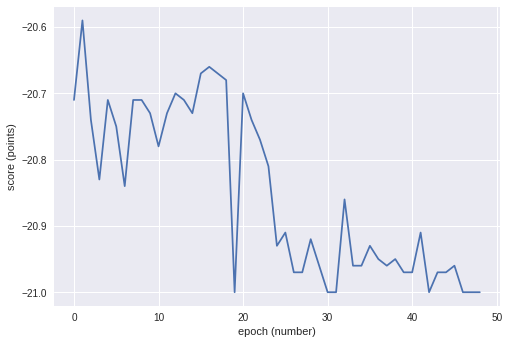

In [27]:
import matplotlib.pyplot as plt
import datetime
import numpy as np

def get_avg(iterable):
    if len(iterable):
        sum_score = sum(i[1] for i in iterable)
        return float(sum_score) / len(iterable)
    return float(-21)

data = [[float(i), get_avg(epoch_info[i])] for i in range(epoch)]
# print(data)
x = np.array([i[0] for i in data], dtype=float)
y = np.array([i[1] for i in data], dtype=float)
# epoch_info2 = epoch_info2
# print(epoch_info2[0])

# epoch_info # [deque((episodio, score), )]
plt.xlabel("epoch (number)")
plt.ylabel("score (points)")
plt.plot(x,y)
plt.show()

Como se puede apreciar en el gráfico anterior, no se logró mejorar sustancialmente el rendimiento del modelo, se muestra, no obstante, un fragmento correspondiente a las últimas 50 épocas de entrenamiento, donde se ve que únicamente hay oscilación entre los valores -20 y -21, teniendo que el modelo en realidad no logra mejorar tras miles de episodios.

**Actividad 3** Se presenta, además de la sección nociones generales con explicaciones sobre el modelo, los parámetros debidamente pedidos en el segundo bloque de código al principio del cuaderno.